In [1]:
from os import path
# import matplotlib.pyplot as plt
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io import json, sbml
from mass.util import qcqa_model
import altair as alt
# from vega_datasets import data
import altair as alt
## lock this version of altair in requirements.txt
import pandas as pd
import numpy as np
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")

## Creating model

In [2]:
from mass.io.json import load_json_model

In [3]:
#  filename="SB2_" + "Glycolysis" + ".json"
glycolysis=load_json_model("SB2_Glycolysis.json")

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-04


In [4]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Glycolysis                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


Successfully loaded MassModel 'Glycolysis' into RoadRunner.


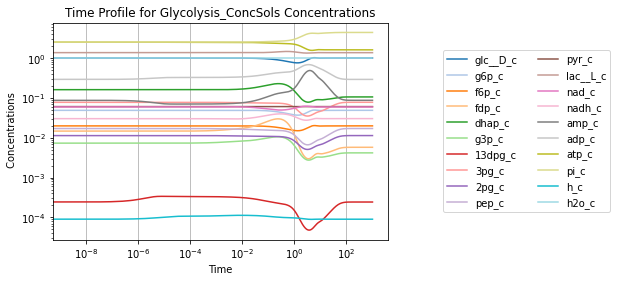

In [5]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
sim.integrator.initial_time_step=1e-6
sim.integrator.maximum_time_step= 1000
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0,1e3),
                                 perturbations={"atp_c": 2.5}
                                  ,interpolate=True
                                 )
# Quickly render and display time profiles
conc_sol.view_time_profile()

#### make xlim and ylim to get the values from the data

In [6]:
from visfxn import set_plot_type, set_plot_type, set_y_label, set_x_label

In [7]:
# function to make xlim
def set_xlim(xlim):
    source=conc_sol.to_frame()
    data = source
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    if xlim == None:
        xlim_max=data['Time'].iloc[-1]
        xlim=[1e-5,xlim_max]

    else:
        xlim=xlim
    return xlim

In [8]:
#function to make ylim 
def set_ylim(ylim):
    source=conc_sol.to_frame()
    data = source
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    if ylim == None:
        conc=data['Concentrations']
        ylim_max=max(conc)
        ylim=[1e-5,ylim_max]
    else:
        ylim=ylim
    return ylim

In [9]:
#old
def plot_conc_sol(conc_sol, observable=None, interactive = False,click= False,  xlim=None,ylim=None,plot_type=None,xlabel=None,
                  ylabel=None,width=None,height=None):
    
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""

    source=conc_sol.to_frame()
    data = source
    if observable == None or observable == "all":
        data=data
    else:
        data = data[observable]
    if interactive== True and observable == None:
        raise Exception("visualisation will be very glitchy, if you want to proceed with all, make observable=""all""") 

    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    data['Concentrations']=round(data['Concentrations'],4)
    data['Time']=round(data['Time'],4)
    alt.data_transformers.disable_max_rows()

    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    
    # Setting width and height
    if width == None:
        width=500
    else:
        width=width
        
    if height == None:
        height=400
    else:
        height=height
    
 
    click = alt.selection_multi(empty='none' # empty selection matches no points
    )

    selection = alt.selection_multi(fields=['Metabolites'])

    color = alt.condition(selection,
                    alt.Color('Metabolites:N', legend=None,scale=alt.Scale(scheme='rainbow')),
                    alt.value('lightgray'))



    line = alt.Chart(data).mark_line(clip=True,size=3).encode(
    alt.X('Time:Q',
    scale=alt.Scale(type = x_plot_type, domain = xlim,),axis=alt.Axis(tickCount=5)),
    alt.Y('Concentrations:Q',title=ylabel,scale=alt.Scale(type=y_plot_type,
    padding = 10,domain = ylim,),axis=alt.Axis(grid=False,tickCount=5)),
    color=color).properties(width=width, height=height)

    hover = alt.selection_single(
        on='mouseover',  # select on mouseover
        nearest=True,    # select nearest point to mouse cursor
        empty='none'     # empty selection should match nothing
    )

    click = alt.selection_multi(
        empty='none' # empty selection matches no points
    )

    # scatter plot encodings shared by all marks
    plot = alt.Chart().mark_circle(size=0).encode(
        alt.X('Time:Q'),
        alt.Y('Concentrations:Q'),
        alt.Color('Metabolites:N', legend=None,scale=alt.Scale(scheme='rainbow'))
    )
    
    # shared base for new layers
    base = plot.transform_filter(
        hover | click # filter to points in either selection
    )

    final=alt.layer(
    line).properties(
    width=500, height=500)

    legend = alt.Chart(data).mark_point(size=100).encode(
    y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),color=color).add_selection(selection)

    #   multi line tooltip
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                    fields=['Time'])

    if interactive == False: 

        line = line.encode(tooltip= ["Metabolites"]+["Time"]+["Concentrations"])
   
        final=alt.layer(line).properties(width=500, height=500)
        final=final|legend 
        # make note that shift click clicks multiple 

    else:
        legend = legend.encode(alt.Shape('Metabolites:N', legend=None))
        # Transparent selectors across the chart. This is what tells us # the x-value of the cursor
        selectors = alt.Chart(data).mark_point().encode(alt.Color('Metabolites:N', legend=None),
            x='Time:Q',
            opacity=alt.value(0)).add_selection(
            nearest)
            # Draw points on the line, and highlight based on selection
        points = line.mark_point(size=150).encode(alt.Shape('Metabolites:N', legend=None),
            opacity=alt.condition(nearest, alt.value(1), alt.value(0))).interactive()

        # Draw text labels near the points, and highlight based on selection
        text = line.mark_text(align='left', dx=8, dy=12).encode(
            text=alt.condition(nearest, 'Concentrations:Q', alt.value(' ')))
        # Draw a rule at the location of the selection
        # rules = alt.Chart(data).mark_rule(color='white').encode(
        #     x='Time:Q').transform_filter(
        #     nearest) 
        final=alt.layer(
            line, selectors, points, 
            # rules,
             text
        ).properties(width=500, height=500)
    # layer scatter plot points, halo annotations, and title labels
        final = alt.layer(
            final,
            plot.add_selection(hover).add_selection(click),
            base.mark_point(size=150, stroke='firebrick', strokeWidth=2).encode(alt.Shape('Metabolites:N', legend=None)),
            base.mark_text(dx=4, dy=-12, align='right', stroke='white', strokeWidth=1).encode(alt.Shape('Metabolites:N', legend=None),text='Conc:'+'Concentrations:Q'),
            base.mark_text(dx=4, dy=-12, align='right',stroke='firebrick', strokeWidth=0.5).encode(alt.Shape('Metabolites:N', legend=None),text='Concentrations:Q'),
            # base.mark_text(dx=10, dy=12, align='right',stroke='firebrick', strokeWidth=0.5).encode(alt.Shape('Metabolites:N', legend=None),text='Time:Q'),
            data=data,
            
        ).properties(
            width=500,
            height=500
        )
        final= final | legend
    return final

In [10]:
plot_conc_sol(conc_sol,
# click=True
# plot_type="linear",
interactive=True,
observable=["atp_c",
"adp_c",
"f6p_c","g6p_c"
],
#  ['PFK'],

)

alt.HConcatChart(...)

In [11]:
from altair_saver import save

In [12]:
chart = plot_conc_sol(conc_sol,interactive=True,
observable=["atp_c", "adp_c", "f6p_c","g6p_c"])
chart.save('chart.html')

In [13]:
import random
import altair as alt
import gif

In [14]:
source=conc_sol.to_frame()
df = source.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')

In [15]:
df.Time

0        0.000000e+00
1        2.000000e-09
2        4.000000e-09
3        8.049287e-09
4        2.075175e-08
             ...     
13635    5.182054e+02
13636    6.037845e+02
13637    6.893635e+02
13638    7.749425e+02
13639    1.000000e+03
Name: Time, Length: 13640, dtype: float64

In [16]:
@gif.frame
def plot(i):
    d = df[df['Time'] == i]
    chart = plot_conc_sol(conc_sol,interactive=True,
    observable=["atp_c", "adp_c", "f6p_c","g6p_c"])
    chart = chart.save('chart.png')
    return chart

In [17]:
frames = []
for time in df.Time.unique():
    frame = plot(time)
    frames.append(frame)

gif.save(frames, 'conc.gif', duration=500)

ValueError: No enabled saver found that supports format='png'

## comparison plots

In [ ]:
def plot_comparison(x, y,  compare=None, observable=None):
    


## Phase portraits

In [ ]:
# making ensemble modelling
#                       ,scale=alt.Scale(scheme='viridis')
# https://uwdata.github.io/visualization-curriculum/altair_scales_axes_legends.html?highlight=grid%20lines

In [ ]:
source=conc_sol.to_frame()
data = source
# data

In [ ]:
def plot_phase_portait(conc_sol,observable=None):
    """Generate an phase portrait"""

    source=conc_sol.to_frame()
    data = source
    if len(observable)== 2: # make an else and error statement
        data = data[observable]   
        data = data.reset_index()
    #             .melt('Time', var_name='Metabolites', value_name='Concentrations')
        # The basic line
        met_1=data.loc[:,observable[0]]
        met_2=data.loc[:,observable[1]]
        line = alt.Chart(data).mark_line().encode(
        alt.X(observable[0]),alt.Y(observable[1]),
        # tooltip=["Time"] + observable
        )
    #   multi line tooltip
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
    fields=['Time'])
    selectors = alt.Chart(data).mark_point().encode(
        # alt.Color('Time:Q', legend=None),
        x='Time:Q',
        opacity=alt.value(0)).add_selection(
        nearest)
        # Draw points on the line, and highlight based on selection
    points = line.mark_point(size=150).encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))).interactive()

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=8, dy=12).encode(
        text=alt.condition(nearest, 'Time:Q', alt.value(' ')))
    # Draw a rule at the location of the selection
    # rules = alt.Chart(data).mark_rule(color='white').encode(
    #     x='Time:Q').transform_filter(
    #     nearest) 
    final=alt.layer(
        line, selectors, points, 
        # rules,
            text
    ).properties(width=500, height=500)
    return final

In [ ]:
plot_phase_portait(conc_sol,observable=["g6p_c","f6p_c"])

In [ ]:
data=conc_sol.to_frame()
source=data
data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
conc=data['Concentrations']
ylim_2=max(conc)
print(ylim_2)

In [ ]:
def obs(observable=None):
    source=conc_sol.to_frame()
    data=source
#     source = source[observable]
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    if ylim == None:
        conc=data['Concentrations']
        ylim_2=max(conc)
    else:
        ylim=xlim
    
    return data

In [ ]:
# obs(observable=["g6p_c","f6p_c"])

In [ ]:
source=conc_sol.to_frame()
data=source
observable=["g6p_c","f6p_c"]
data = data[observable]

In [ ]:
# for name, values in source.iteritems():
#     values=round(values,4)
#     source.loc[name] = values
# source

In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]
        # +["Concentrations"]
    ).properties(width=width, height=height).interactive()

    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [ ]:
view_all_conc_sol(conc_sol,plot_type='logxlogy',xlim=[1e-3,1e3],xlabel="T")

In [ ]:
# chart.save('chart.html', embed_options={'renderer':'svg'})
# chart.save('chart.png')
# chart.save('chart.svg')
# chart.save('chart.pdf')
# https://altair-viz.github.io/user_guide/saving_charts.html?highlight=to_json

In [ ]:
## from chart to JSON abd vice versa
# pymodulon: testing on visualisation fxns
